9.4 cnn 模型可视化

计算机视觉模型应用时,一个基本问题是可解释性问题: 为什么图像是一个冰箱,模型却解析出了卡车?

出现这样结果和输入模型的用例相关,这一节我们会熟悉一系列不同的技术,可视化模型学习的内容,尝试理解模型做的判断.

深度学习模型一直被当做黑盒,模型提取的特征对人类几乎没有可读性.但是 cnn 模型这里不一样,本身 cnn 处理的是人眼看到的图像信息,cnn 的模型非常适合可视化,在 2013 年以后就有一系列可视化/解释技术,这里不会介绍全部,只是 3 种最容易理解的技术.

- 卷积核的可视化(中间激活的可视化)(Visualizing intermediate convnet outputs (intermediate activations)): 理解连续的 cnn 层如何转换输入,对单个的 cnn 过滤器的效果有初步的了解.
- 过滤器的可视化(Visualizing convnets filters): 有助于理解 cnn 种每个过滤器所接受的视觉模式(??没太懂??)
- 激活类的热力图?(Visualizing heatmaps of class activation in an image): 有助于理解图像中那个部分成了哪一类的标记.

卷积核的可视化会使用 8.2 节的猫狗分类模型,后两种方法会使用 VGG16.


## 卷积核的可视化

可视化中间激活,包括输入一张图片,显示模型各个卷积层和池化层的输出.这样很明确能看到图片是如何被一层层拆解的.

在深度可分离卷积那里提到了各个通道都编码了独立的特征,可视化时需要将每个通道的内容单独绘制成 2d 图像.


In [2]:
from tensorflow import keras

model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")

这里加载 8.2 小节保存的模型


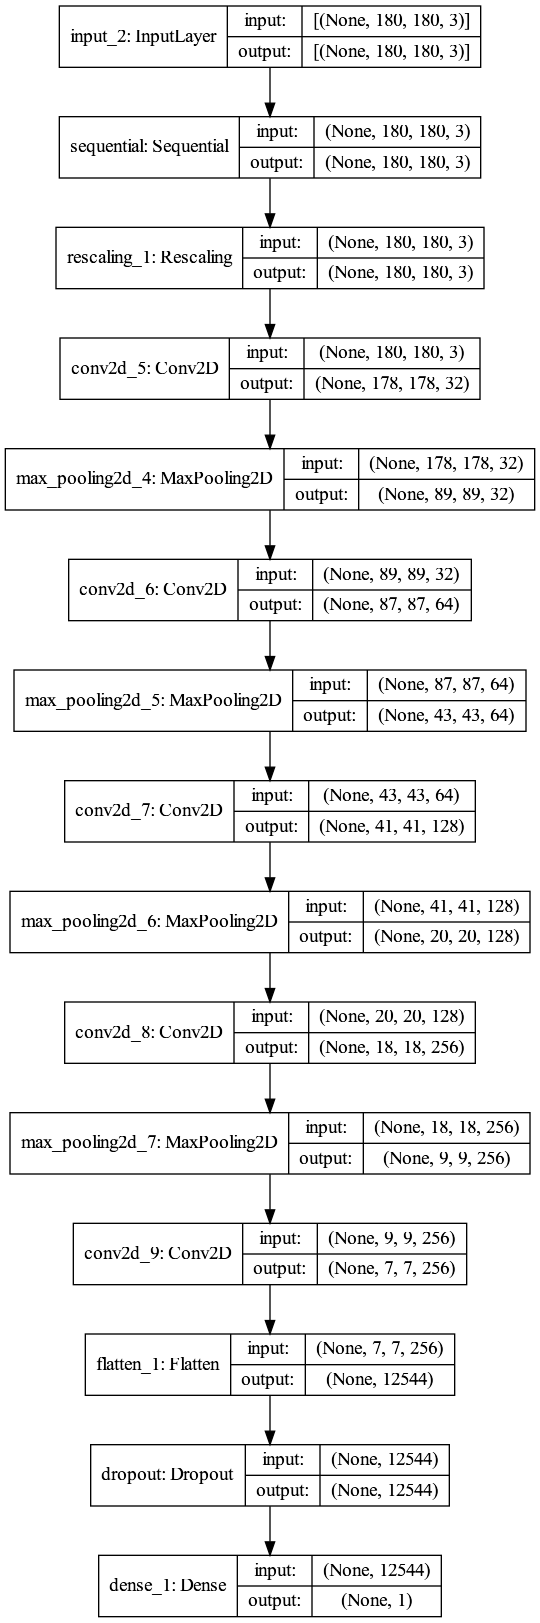

In [6]:
keras.utils.plot_model(model, "9.4.1.png", show_shapes=True)

In [4]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg")


def get_img_array(img_path, target_size):
    img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


img_tensor = get_img_array(img_path, target_size=(180, 180))

81920/80329 [==============================] - 0s 6us/step


我们这里是从网上下载了一张图片,并非是原有数据集的图片.


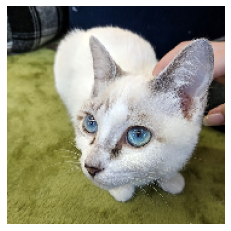

In [5]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [7]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:  #获取 model 所有层的数据
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

为了捕获 model 的每层的特征图,这里创建 activation_model,获取 model 所有层的数据


In [8]:
activations = activation_model.predict(img_tensor)

获取预测值,接下来就一层一层的输出.


In [10]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


第一层是 178*178*32 有 32 个通道.


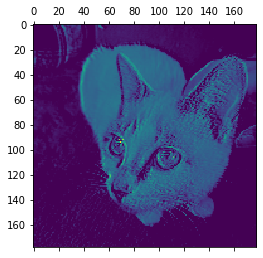

In [15]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap="viridis")

这里绘制了第 5 个通道的图,似乎是把猫整个抠出来了.

注意因为初始化参数等都不一样,训练出的模型不同通道会有所不同,原书中第 4 通道是边缘检测.


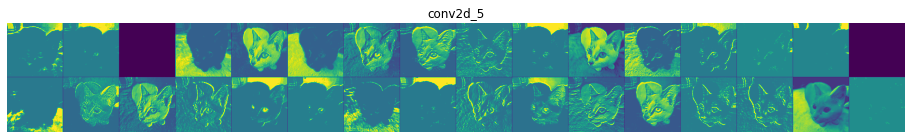

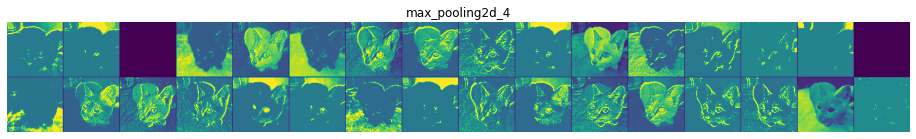

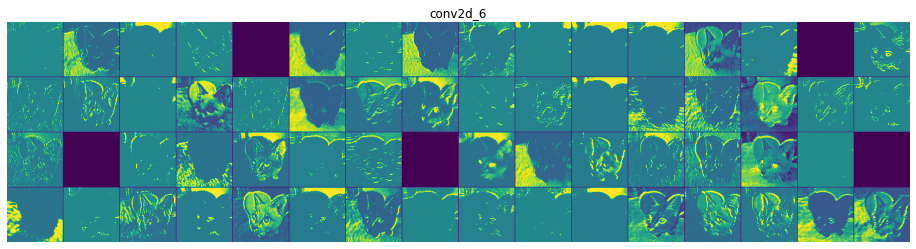

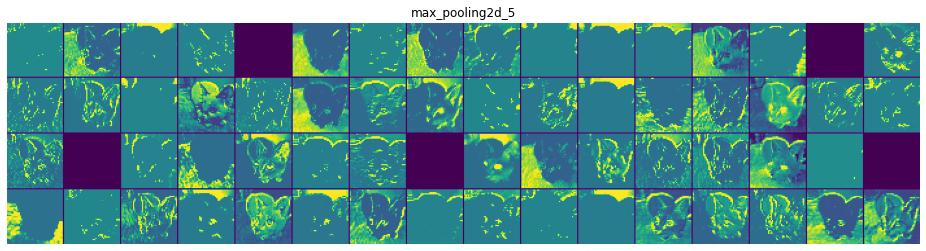

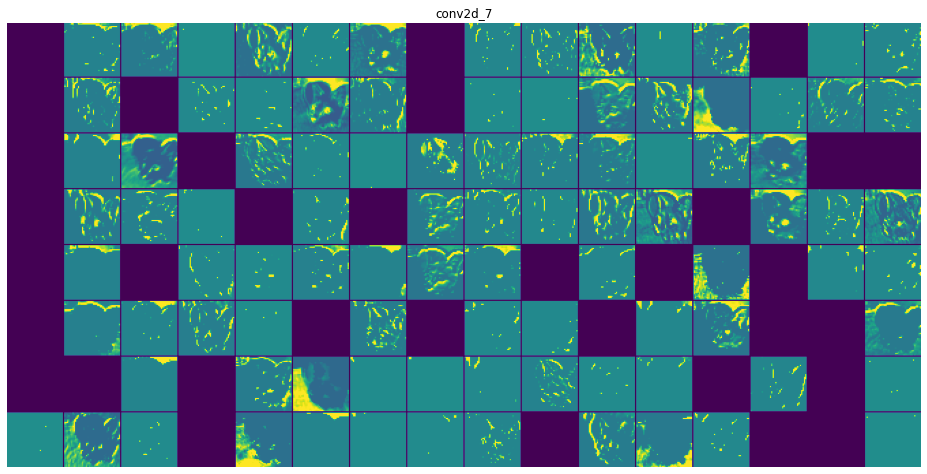

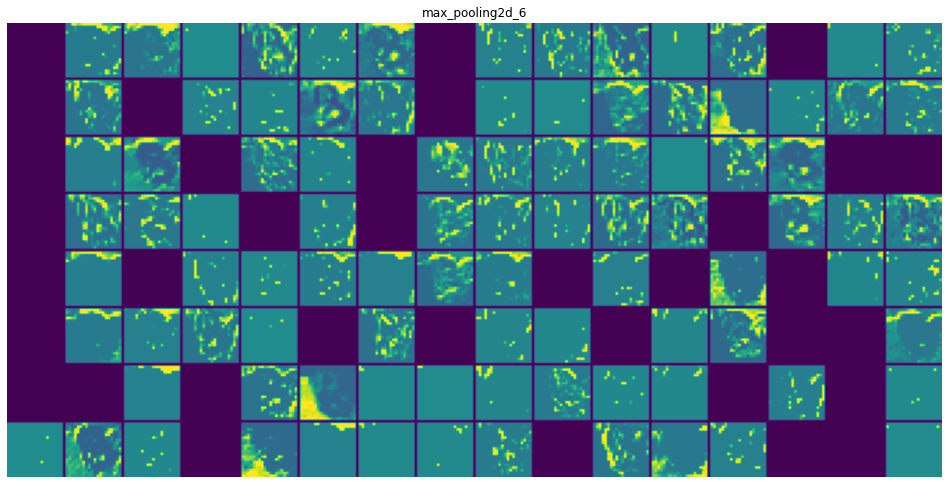

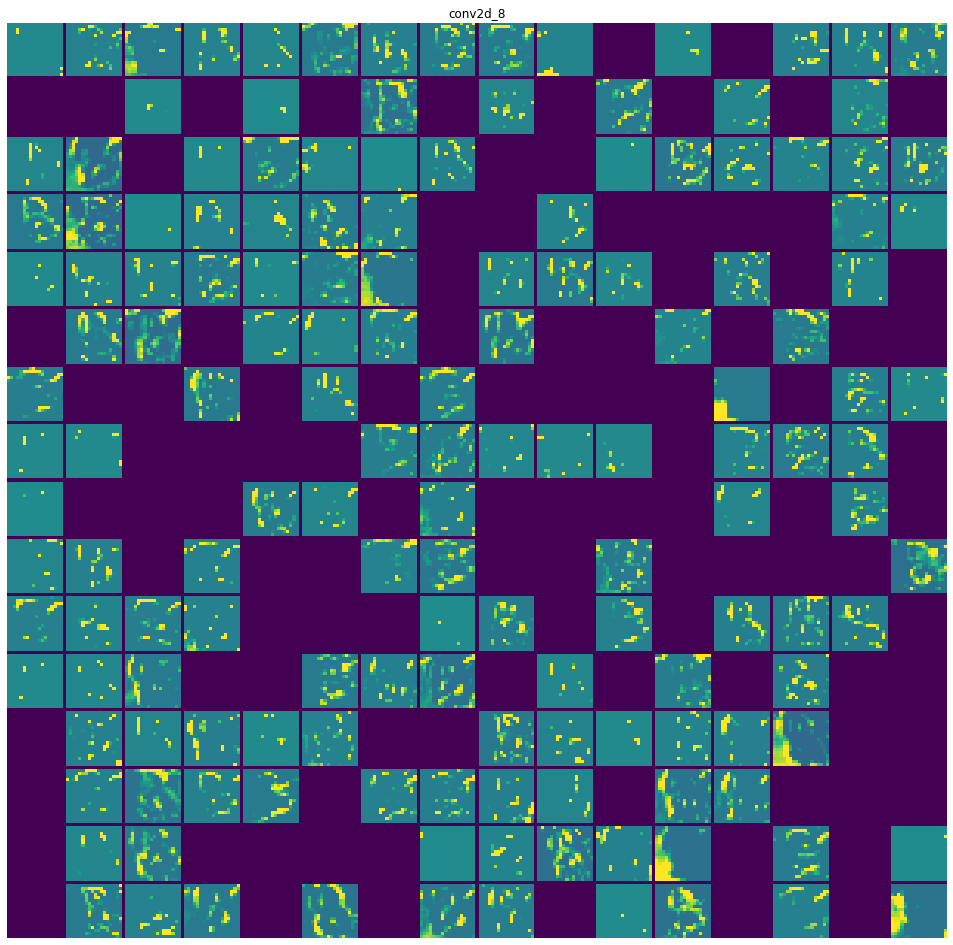

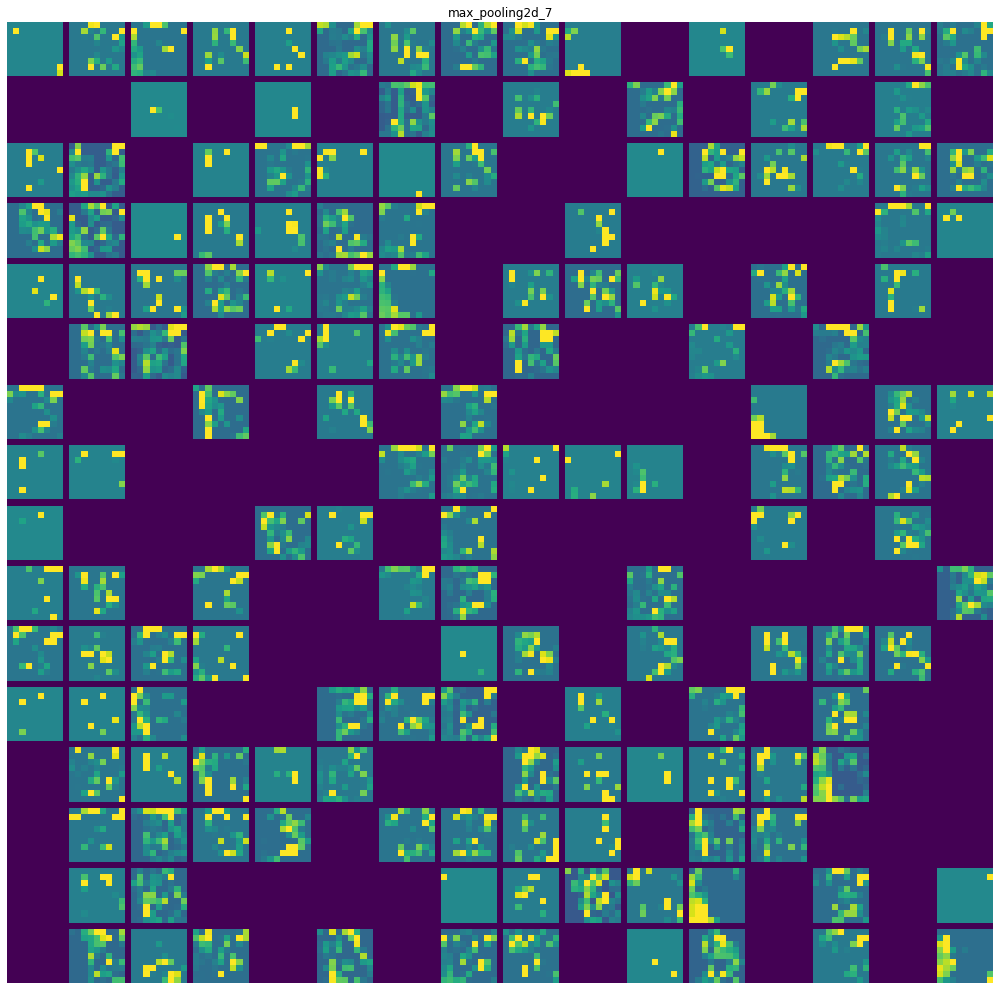

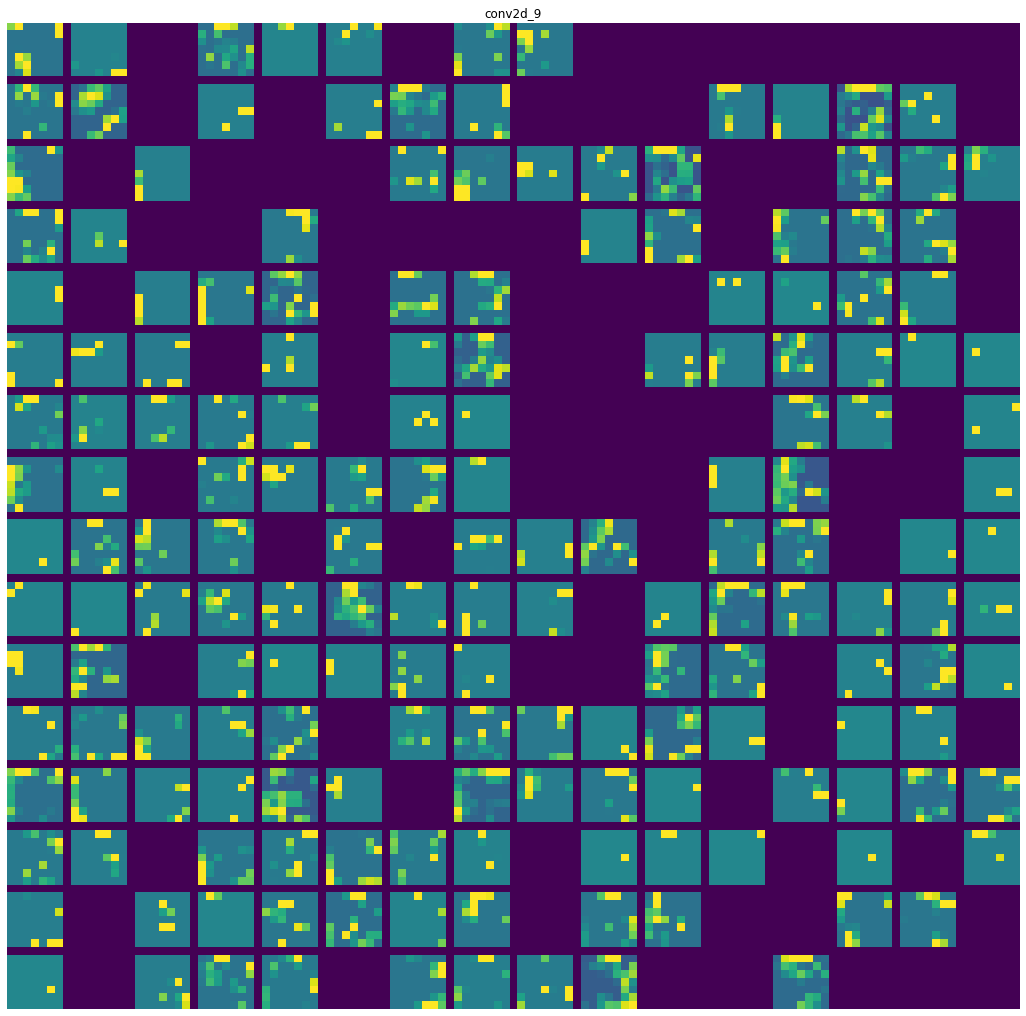

In [16]:
images_per_row = 16  #每行显示的图片数量
for layer_name, layer_activation in zip(layer_names, activations):  #
    n_features = layer_activation.shape[-1]  #获取每个层通道数量
    size = layer_activation.shape[1]  #获取每个层的尺寸
    n_cols = n_features // images_per_row  #计算需要显示多少行图片
    display_grid = np.zeros(
        ((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))  #创建一个空白的图片
    for col in range(n_cols):  #填充空白图片
        for row in range(images_per_row):  #每行
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :,
                                             channel_index].copy()  #取通道数据
            if channel_image.sum() != 0:  #如果通道数据相加不为0
                channel_image -= channel_image.mean()  #减去均值
                channel_image /= channel_image.std()  #除以标准差
                channel_image *= 64  #乘以64
                channel_image += 128  #加上128
            channel_image = np.clip(channel_image, 0,
                                    255).astype("uint8")  #将数据转换为0-255
            display_grid[col * (size + 1):(col + 1) * size + col,
                         row * (size + 1):(row + 1) * size +
                         row] = channel_image  #将图片填充到空白图片中
    scale = 1. / size  #计算缩放比例
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)  #layer 名称
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

每一层都画出来了

- 第一层几乎保留了原图的所有信息.
- 随着深度加深,图片越来越抽象,人类能看懂的视觉信息越来越少.
- 深度越深,图片越来越稀疏,空白的通道越来越多.这意味输入图片没有这一层的这个通道所对应的特征.



深度神网络学习模式都会是这样,随着深度越深,提取到的特征越抽象.高层的激活所携带的信息越来越难以从原始输入直接对应上.神经网络像是人类不能完全了解的滤网,一层一层的将信息提炼,对问题有用的信息被放大,无关信息被丢弃.

这个过程和人类识别物体方式非常类似,我们能快速记住的是这个图片里面有自行车,而不是图片自行车的全部细节.事实上现在让你画出行车,绝大多数人都只能画个轮廓,细节不能深究.但是其他人还能分辨出这画的是自行车.

我们的大脑已经在不知不觉中过滤掉了细节,只留下了我们需要记住的轮廓.

![bicycles](bicycles.png)
